# Assignment 1: Data Parsing, Cleansing and Integration
## Task 1 and 2
#### Student Name: Denzel Tan
#### Student ID: s3900098

Date: 8/2021

Version: 1.0

Environment: Python 3 and Jupyter notebook

Libraries used: please include the main libraries you used in your assignment, e.g.,:
* pandas
* re
* numpy

## Introduction
Brief information of this assessment, e.g., what problems were this assessment tackling, what problems were discovered in the data while you were parsing or cleansing it, and the approaches you chose to handle them, etc.

<span style="color: red"> Note that this is a sample notebook only. You will need to fill in the proper markdown and code blocks. You might also want to make necessary changes to the structure to meet your own needs. Note also that any generic comments written in this notebook are to be removed and replace with your own words.</span>

## Importing libraries 

In [1]:
# Code to import libraries as you need in this assessment, e.g.,
import pandas as pd
import re
import numpy as np
import xml.etree.ElementTree as etree
from datetime import datetime

# Visualisation tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab


## Task 1. Parsing Data

### 1.1. Examining and loading data
Examine "\<student\_id\>_dataset1.xml" to determine its content and structure, then load it into Python. Explain your findings here, e.g., how are the records are stored? 

Lets do some initial Exploratry Data Analysis!

In [2]:
# Code to inspect the provided data file
# Couple of notes for all code block in this notebook
## please provide proper comment on your code
## Please re-start and run all cells to make sure codes are runable and include your output in the submission

In [3]:
# Parsing the XML file via Element Tree (BSoup was very slow)
tree = etree.parse("S3900098_dataset1.xml")

In [4]:
# Finding the root of the entire XML, it all falls under JobAds
root = tree.getroot()
root.tag

'JobAds'

### Uncomment below if you want to see the tree.

### It takes very long though....

In [5]:
# HIT THE STOP BUTTON ON THIS IF JUPYTER IS NOT LOADING WHATS BELOW!!!!
# Lets have a look at what the XML looks like:

#for elem in tree.iter():
    #print (elem.tag, elem.text, elem.attrib)

In [6]:
# Finding how many job records/listings in each "source" (which is the job website)
[len(child) for child in root]

[226,
 2966,
 359,
 7384,
 1149,
 2058,
 8372,
 71,
 814,
 2319,
 2715,
 1094,
 333,
 3039,
 277,
 17,
 177,
 9,
 301,
 1074,
 1956,
 1123,
 357,
 65,
 284,
 461,
 435,
 615,
 86,
 83,
 285,
 1570,
 310,
 617,
 184,
 668,
 130,
 92,
 385,
 401,
 80,
 101,
 113,
 161,
 30,
 587,
 208,
 79,
 59,
 50,
 75,
 139,
 281,
 58,
 591,
 236,
 135,
 172,
 71,
 111,
 41,
 362,
 27,
 123,
 37,
 94,
 134,
 197,
 142,
 78,
 142,
 115,
 20,
 86,
 132,
 49,
 56,
 28,
 58,
 96,
 26,
 65,
 44,
 26,
 64,
 126,
 14,
 22,
 25,
 17,
 31,
 9,
 4,
 50,
 7,
 9,
 2,
 8,
 5,
 10,
 7,
 5,
 10,
 2,
 2,
 3,
 2]

Alright nice. So we know that the Sources (job websites) have multiple records (job listings), but what are 
the children of the records (job details)? 
Lets find out all the different details that could take place!


In [7]:
# Shows how many children for each of the records (how many job attributes) within the 1st source
[len(child) for child in root[0]]
# So each listing may have different number of children (job attributes)!

[0,
 6,
 6,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 6,
 7,
 6,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 6,
 7,
 5,
 6,
 7,
 6,
 6,
 6,
 7,
 6,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 7,
 6,
 6,
 6,
 6,
 6,
 8,
 7,
 6,
 7,
 6,
 7,
 8,
 7,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 7,
 6,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 6,
 6,
 6,
 6,
 7,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 6,
 6,
 7,
 6,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 7,
 6,
 6,
 6,
 5,
 7,
 6,
 6,
 5,
 7,
 7,
 6,
 7,
 5,
 6,
 5,
 6,
 7,
 5,
 6,
 6,
 6,
 6,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 6,
 7,
 6,
 6,
 6,
 6,
 6,
 7,
 6,
 6,
 6,
 7,
 6,
 7,
 7,
 6,
 6,
 6,
 7,
 6,
 6,
 6,
 7,
 7,
 6,
 5,
 7,
 6,
 6,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 6,
 6,
 7,
 6,
 6,
 6,
 7,
 7,
 7,
 6,
 6,
 7,
 6,
 7,
 6,
 6,
 6,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 6,
 7,
 7,
 7,
 6,
 7,
 6,
 5]

In [8]:
set([child.tag for child in root[0][1]]) # Shows tags of the 1st record of the 1st source

{'Category', 'Date', 'Id', 'Location', 'Salary', 'Title'}

In [9]:
# Now we iterate through all the sources and get a set of the children of records FOR EACH record.
# Notice how the first only has 6, while most of the others have 9.

[set([child.tag for child in root[i][1]]) for i in range(0, len(root))]

[{'Category', 'Date', 'Id', 'Location', 'Salary', 'Title'},
 {'Category',
  'Company',
  'ContractTime',
  'ContractType',
  'Date',
  'Id',
  'Location',
  'Salary',
  'Title'},
 {'Category',
  'Company',
  'ContractTime',
  'ContractType',
  'Date',
  'Id',
  'Location',
  'Salary',
  'Title'},
 {'Category',
  'Company',
  'ContractTime',
  'ContractType',
  'Date',
  'Id',
  'Location',
  'Salary',
  'Title'},
 {'Category',
  'Company',
  'ContractTime',
  'ContractType',
  'Date',
  'Id',
  'Location',
  'Salary',
  'Title'},
 {'Category',
  'Company',
  'ContractType',
  'Date',
  'Id',
  'Location',
  'Salary',
  'Title'},
 {'Category',
  'Company',
  'ContractTime',
  'Date',
  'Id',
  'Location',
  'Salary',
  'Title'},
 {'Category',
  'Company',
  'ContractTime',
  'ContractType',
  'Date',
  'Id',
  'Location',
  'Salary',
  'Title'},
 {'Category',
  'Company',
  'ContractTime',
  'ContractType',
  'Date',
  'Id',
  'Location',
  'Salary',
  'Title'},
 {'Category',
  'Company

In [10]:
# Here we get the set of ALL POSSIBLE tags for the job details, collated into a single set. So we have a max
# of 9 children per record, for all the records in the XML.
# This basically takes every unique child from above and puts it into a set!
from itertools import chain
record_features = set(chain.from_iterable([[child.tag for child in root[i][1]] for i in range(0, len(root))]))
record_features

{'Category',
 'Company',
 'ContractTime',
 'ContractType',
 'Date',
 'Id',
 'Location',
 'Salary',
 'Title'}

Alright initial analysis done! Now we have a better idea of whats in our data. Lets move onto parsing our data into a DataFrame
.

### 1.2 Parsing data into the required format

<span style="color: red"> You might have complex notebook structure in this section, please feel free to create your own notebook structure. </span>

In [11]:
# Code to parse data

In [12]:
record_features

{'Category',
 'Company',
 'ContractTime',
 'ContractType',
 'Date',
 'Id',
 'Location',
 'Salary',
 'Title'}

So we have data in the SourceName + the record features listed above. Lets extract the data from these tags!
We should have 10 columns in the DataFrame... Or is it more?

Lets first tackle the dates, as this is the tricky one

In [13]:
opendate_data = []
for elem in tree.findall('Source/Record/Date'):
    opendate_data.append(elem.attrib)
    
print('Opendate:',len(opendate_data))
opendate_data

Opendate: 50703


[{'Open': '20120531T150000', 'Close': '20120614T150000'},
 {'Open': '20131119T000000', 'Close': '20140118T000000'},
 {'Open': '20131211T150000', 'Close': '20131225T150000'},
 {'Open': '20120301T000000', 'Close': '20120315T000000'},
 {'Open': '20131124T120000', 'Close': '20131208T120000'},
 {'Open': '20120511T120000', 'Close': '20120710T120000'},
 {'Open': '20121026T120000', 'Close': '20121109T120000'},
 {'Open': '20131023T120000', 'Close': '20131222T120000'},
 {'Open': '20130904T150000', 'Close': '20131103T150000'},
 {'Open': '20120504T000000', 'Close': '20120703T000000'},
 {'Open': '20120201T150000', 'Close': '20120401T150000'},
 {'Open': '20130626T000000', 'Close': '20130924T000000'},
 {'Open': '20120615T000000', 'Close': '20120715T000000'},
 {'Open': '20120215T000000', 'Close': '20120316T000000'},
 {'Open': '20130608T150000', 'Close': '20130807T150000'},
 {'Open': '20120923T150000', 'Close': '20121007T150000'},
 {'Open': '20120505T120000', 'Close': '20120704T120000'},
 {'Open': '201

In [14]:
print(type(opendate_data))
print(opendate_data[0])
print(type(opendate_data[0]))

<class 'list'>
{'Open': '20120531T150000', 'Close': '20120614T150000'}
<class 'dict'>


In [15]:
print(opendate_data[0]['Open'])
print(opendate_data[0]["Close"])
print(type(opendate_data[0]["Close"]))

20120531T150000
20120614T150000
<class 'str'>


Ohh. Each "Date" is actually a Dictionary, with the keys "Open" and "Close" corresponding to the Opening date and Close date respectively. Lets try seperating them.

In [16]:
# Open Date
opendate_data = []
for elem in tree.findall('Source/Record/Date'):
    opendate_data.append(elem.attrib['Open'])
    
print('Opendate:',len(opendate_data))
opendate_data

Opendate: 50703


['20120531T150000',
 '20131119T000000',
 '20131211T150000',
 '20120301T000000',
 '20131124T120000',
 '20120511T120000',
 '20121026T120000',
 '20131023T120000',
 '20130904T150000',
 '20120504T000000',
 '20120201T150000',
 '20130626T000000',
 '20120615T000000',
 '20120215T000000',
 '20130608T150000',
 '20120923T150000',
 '20120505T120000',
 '20120109T120000',
 '20121128T000000',
 '20131005T150000',
 '20130702T150000',
 '20121123T000000',
 '20120503T000000',
 '20130621T150000',
 '20120118T000000',
 '20130320T000000',
 '20120825T150000',
 '20130613T000000',
 '20121027T150000',
 '20121231T150000',
 '20120620T150000',
 '20130416T150000',
 '20120129T150000',
 '20121024T120000',
 '20120721T120000',
 '20121210T000000',
 '20130309T150000',
 '20120323T000000',
 '20130330T000000',
 '20120504T000000',
 '20120926T000000',
 '20131202T150000',
 '20130414T150000',
 '20120120T000000',
 '20120701T120000',
 '20120901T150000',
 '20130910T150000',
 '20120925T000000',
 '20120512T000000',
 '20121128T150000',


In [17]:
# Close Date
closedate_data = []
for elem in tree.findall('Source/Record/Date'):
    closedate_data.append(elem.attrib['Close'])
    
print('Close date:',len(closedate_data))
closedate_data

Close date: 50703


['20120614T150000',
 '20140118T000000',
 '20131225T150000',
 '20120315T000000',
 '20131208T120000',
 '20120710T120000',
 '20121109T120000',
 '20131222T120000',
 '20131103T150000',
 '20120703T000000',
 '20120401T150000',
 '20130924T000000',
 '20120715T000000',
 '20120316T000000',
 '20130807T150000',
 '20121007T150000',
 '20120704T120000',
 '20120309T120000',
 '20130127T000000',
 '20131104T150000',
 '20130716T150000',
 '20121207T000000',
 '20120602T000000',
 '20130820T150000',
 '20120217T000000',
 '20130403T000000',
 '20121024T150000',
 '20130713T000000',
 '20121226T150000',
 '20130130T150000',
 '20120720T150000',
 '20130516T150000',
 '20120228T150000',
 '20121123T120000',
 '20120919T120000',
 '20130310T000000',
 '20130607T150000',
 '20120422T000000',
 '20130628T000000',
 '20120603T000000',
 '20121125T000000',
 '20140101T150000',
 '20130428T150000',
 '20120219T000000',
 '20120830T120000',
 '20121001T150000',
 '20131010T150000',
 '20121009T000000',
 '20120711T000000',
 '20130127T150000',


So we are able to seperate it!

This means there will be 11 columns in total now, since date is now split into Open and Close.

Lets put it in the dataframe now

In [18]:
# We should have 11 columns
columns = ["Id","Title","Source","Location","Company","Category","Salary","OpenDate","CloseDate","ContractType","ContractTime",]

## Start by putting all our data into lists
This is where we will store all our data into lists
This part was especially tricky, since some records have a different nunber of children (job details), which means they don't carry equal information.

If we just capture the data without taking in the missing children as null, our columns would be different length.

This makes it quite hard, as this means each column in our dataframe would be out of order, and missing lots of data where the ordered null was meant to be.

Hence, we must find a way to capture the missing children as null!

We solve this by iterating through every single Job Detail, turning that data into a list, then appending it to a bigger list.
This allows us to capture null Job Details of Records.
Hence the length of all rows should be 50703! If that is the length, we can be sure all values, including the empty, are captured into the list

In [19]:
# Id
id_list = []
for elem in tree.iter(tag = 'Record'):
    id_list.append([child.text for child in elem.findall("Id")])
    
        
print(len(id_list))
id_list

50703


[['71338111'],
 ['71353268'],
 ['69117049'],
 ['68562480'],
 ['69783035'],
 ['69123410'],
 ['69568845'],
 ['69783086'],
 ['69574695'],
 ['68652203'],
 ['69568570'],
 ['66557414'],
 ['71337872'],
 ['66578111'],
 ['71337767'],
 ['67304105'],
 ['71337740'],
 ['71338003'],
 ['69123437'],
 ['69145185'],
 ['70229115'],
 ['69783630'],
 ['67155606'],
 ['67155987'],
 ['69816548'],
 ['71082357'],
 ['69145236'],
 ['69167060'],
 ['70229116'],
 ['72170961'],
 ['71110688'],
 ['71337990'],
 ['69783080'],
 ['69166564'],
 ['69123415'],
 ['68603122'],
 ['66072605'],
 ['66713310'],
 ['69166851'],
 ['69123418'],
 ['68580301'],
 ['69783635'],
 ['71337802'],
 ['69116936'],
 ['69166844'],
 ['71082697'],
 ['69816617'],
 ['67155596'],
 ['71337994'],
 ['69973847'],
 ['66713101'],
 ['71337419'],
 ['71337798'],
 ['69973795'],
 ['69973880'],
 ['66577533'],
 ['68652091'],
 ['66713420'],
 ['71338037'],
 ['68562514'],
 ['69116955'],
 ['70645899'],
 ['70645776'],
 ['69123298'],
 ['71846200'],
 ['66557412'],
 ['7133774

In [20]:
# Salary
salary_list = []
for elem in tree.iter(tag = 'Record'):
    salary_list.append([child.text for child in elem.findall("Salary")])
    
        
print(len(salary_list))
salary_list

50703


[['32000'],
 ['22950'],
 [],
 ['50000'],
 ['14500'],
 ['30160'],
 ['18500'],
 ['14575'],
 ['60000'],
 ['24462'],
 ['14500'],
 ['27500'],
 ['30000'],
 ['50000'],
 ['36000'],
 ['39000'],
 ['20800'],
 ['28000'],
 ['50000'],
 ['29500'],
 ['13000'],
 ['21250'],
 ['22000'],
 ['38000'],
 ['40000'],
 ['37500'],
 ['26000'],
 [],
 ['13000'],
 ['32500'],
 ['16000'],
 ['19500'],
 ['37500'],
 ['28500'],
 ['55000'],
 ['56000'],
 ['24000'],
 ['24500'],
 ['27040'],
 ['44000'],
 ['59000'],
 ['21500'],
 ['55250'],
 ['40500'],
 ['28000'],
 ['20779'],
 ['27500'],
 ['27500'],
 ['20500'],
 ['42500'],
 ['30000'],
 ['33000'],
 ['13500'],
 ['28000'],
 ['38500'],
 ['57500'],
 ['31200'],
 ['29281'],
 ['21500'],
 ['38500'],
 ['19000'],
 ['27000'],
 ['25000'],
 ['17000'],
 ['24355'],
 ['30000'],
 ['23400'],
 ['37500'],
 ['27500'],
 ['36000'],
 ['19500'],
 ['52500'],
 ['42500'],
 ['45000'],
 ['41250'],
 ['20000'],
 ['56000'],
 ['45000'],
 ['39000'],
 ['54500'],
 ['21500'],
 ['42500'],
 ['14000'],
 ['25740'],
 ['500

In [21]:
# Title
title_list = []
for elem in tree.iter(tag = 'Record'):
    title_list.append([child.text for child in elem.findall("Title")])
    
        
print(len(title_list))
title_list

50703


[['Allied Health Care Professional : Nurse Manager Jobs in Cornwall'],
 ['Dental : Registered General Nurse Jobs in Stevenage'],
 ['Allied Health Care Professional : Optometrists Jobs in Aberdeen'],
 ['Allied Health Care Professional : Care Home Managers Jobs in Essex'],
 ['Allied Health Care Professional : Optical Clinical Assistant Jobs in Aberdeen'],
 ['Dental : Deputy Care Home Manager Jobs in Hertfordshire'],
 ['Doctor : Staff Nurse (Nights) Job in Halifax'],
 ['Allied Health Care Professional : Optical Clinical Assistant Jobs in Falkirk'],
 ['Dental : Associate Dentist Jobs in Dorset'],
 ['Nurse : Renal Nurse Positions ZC****'],
 ['Allied Health Care Professional : Optical Advisor Jobs in West Wickham'],
 ['Nurse : Staff Nurse – Outpatients & Pre assessment'],
 ['Allied Health Care Professional : Optical Manager Jobs in Suffolk'],
 ['Doctor : Middle Grade Doctor  Nottinghamshire CDH****'],
 ['Allied Health Care Professional : Radiography  Mobile Senior CT Radiographer Jobs i'],
 

In [22]:
# Source
# This is different to the rest, as we need to append the same source multiple times, for each individual record 
# in the xml within that source.
source_list = []

for elem in root:
    name = elem[0].text    
    for job in elem.findall('Record'):
        source_list.append(name)
        
print(len(source_list))
source_list

50703


['jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medical.co.uk',
 'jobs4medi

In [23]:
# Location
location_list = []
for elem in tree.iter(tag = 'Record'):
    location_list.append([child.text for child in elem.findall("Location")])
    
        
print(len(location_list))
location_list

50703


[['Cornwall'],
 ['Hertfordshire'],
 ['Aberdeenshire'],
 ['Essex'],
 ['Aberdeenshire'],
 ['Hertfordshire'],
 ['West Yorkshire'],
 ['UK'],
 ['Dorset'],
 ['UK'],
 ['Central London'],
 ['Berkshire'],
 ['Suffolk'],
 ['West Yorkshire'],
 ['West Yorkshire'],
 ['Lancashire'],
 ['Lincolnshire'],
 ['Norfolk'],
 ['Kent'],
 ['Suffolk'],
 ['Dorset'],
 ['Cornwall'],
 ['Derbyshire'],
 ['Hertfordshire'],
 ['West London'],
 ['North Yorkshire'],
 ['West Yorkshire'],
 ['Bedfordshire'],
 ['West Sussex'],
 ['Nottinghamshire'],
 ['Oxfordshire'],
 ['Newcastle Upon Tyne'],
 ['Llandaff North'],
 ['Antrim'],
 ['Somerset'],
 ['South East London'],
 ['West Midlands'],
 ['Nottinghamshire'],
 ['Suffolk'],
 ['Durham'],
 ['Somerset'],
 ['Kent'],
 ['Kent'],
 ['Berkshire'],
 ['Oxfordshire'],
 ['UK'],
 ['Central London'],
 ['Cheshire'],
 ['Lancashire'],
 ['Somerset'],
 ['Kent'],
 ['Central London'],
 ['Central London'],
 ['Kent'],
 ['Cornwall'],
 ['Hertfordshire'],
 ['Berkshire'],
 ['Central London'],
 ['Durham'],
 ['We

In [24]:
# Company
company_list = []
for elem in tree.iter(tag = 'Record'):
    company_list.append([child.text for child in elem.findall("Company")])
    
        
print(len(company_list))
company_list

50703


[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],


In [25]:
# Category
category_list = []
for elem in tree.iter(tag = 'Record'):
    category_list.append([child.text for child in elem.findall("Category")])
    
        
print(len(category_list))
category_list

50703


[['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healthcare & Nursing Jobs'],
 ['Healt

In [26]:
# ContractType
contractType_list = []
for elem in tree.iter(tag = 'Record'):
    contractType_list.append([child.text for child in elem.findall("ContractType")])

        
print(len(contractType_list))
contractType_list

50703


[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['part_time'],
 [],
 [],
 [],
 [],
 [],
 ['part_time'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []

In [27]:
# ContractTime
contractTime_list = []
for elem in tree.iter(tag = 'Record'):
    contractTime_list.append([child.text for child in elem.findall("ContractTime")])

        
print(len(contractTime_list))
contractTime_list

50703


[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['permanent'],
 [],
 ['permanent'],
 [],
 ['permanent'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['permanent'],
 [],
 ['permanent'],
 [],
 [],
 ['permanent'],
 [],
 [],
 [],
 ['permanent'],
 [],
 ['permanent'],
 ['permanent'],
 ['permanent'],
 ['permanent'],
 [],
 [],
 [],
 [],
 [],
 ['permanent'],
 [],
 [],
 [],
 [],
 [],
 ['permanent'],
 ['permanent'],
 [],
 ['permanent'],
 [],
 ['permanent'],
 ['permanent'],
 ['permanent'],
 [],
 [],
 [],
 ['permanent'],
 ['permanent'],
 ['permanent'],
 ['permanent'],
 ['permanent'],
 [],
 [],
 ['permanent'],
 [],
 ['permanent'],
 ['permanent'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['permanent'],
 [],
 [],
 [],
 [],
 ['permanent'],
 [],
 [],
 [],
 [],
 ['permanent'],
 ['permanent'],
 ['permanent'],
 [],
 [],
 ['permanent'],
 [],
 ['permanent'],
 ['permanent'],
 ['permanent'],
 [],
 [],
 [],
 [],
 ['permanent'],
 [],
 ['permanent'],
 [],
 [],
 ['permanent'],
 [],
 [],
 [],
 ['permanent'],
 ['per

In [28]:
columns

['Id',
 'Title',
 'Source',
 'Location',
 'Company',
 'Category',
 'Salary',
 'OpenDate',
 'CloseDate',
 'ContractType',
 'ContractTime']

In [29]:
# Open Date
openDate_list = []
for elem in tree.iter(tag = 'Record'):
    openDate_list.append([child.attrib['Open'] for child in elem.findall("Date")])

        
print(len(openDate_list))
openDate_list

50703


[['20120531T150000'],
 ['20131119T000000'],
 ['20131211T150000'],
 ['20120301T000000'],
 ['20131124T120000'],
 ['20120511T120000'],
 ['20121026T120000'],
 ['20131023T120000'],
 ['20130904T150000'],
 ['20120504T000000'],
 ['20120201T150000'],
 ['20130626T000000'],
 ['20120615T000000'],
 ['20120215T000000'],
 ['20130608T150000'],
 ['20120923T150000'],
 ['20120505T120000'],
 ['20120109T120000'],
 ['20121128T000000'],
 ['20131005T150000'],
 ['20130702T150000'],
 ['20121123T000000'],
 ['20120503T000000'],
 ['20130621T150000'],
 ['20120118T000000'],
 ['20130320T000000'],
 ['20120825T150000'],
 ['20130613T000000'],
 ['20121027T150000'],
 ['20121231T150000'],
 ['20120620T150000'],
 ['20130416T150000'],
 ['20120129T150000'],
 ['20121024T120000'],
 ['20120721T120000'],
 ['20121210T000000'],
 ['20130309T150000'],
 ['20120323T000000'],
 ['20130330T000000'],
 ['20120504T000000'],
 ['20120926T000000'],
 ['20131202T150000'],
 ['20130414T150000'],
 ['20120120T000000'],
 ['20120701T120000'],
 ['2012090

In [30]:
# Close Date
closeDate_list = []
for elem in tree.iter(tag = 'Record'):
    closeDate_list.append([child.attrib['Close'] for child in elem.findall("Date")])

        
print(len(closeDate_list))
closeDate_list

50703


[['20120614T150000'],
 ['20140118T000000'],
 ['20131225T150000'],
 ['20120315T000000'],
 ['20131208T120000'],
 ['20120710T120000'],
 ['20121109T120000'],
 ['20131222T120000'],
 ['20131103T150000'],
 ['20120703T000000'],
 ['20120401T150000'],
 ['20130924T000000'],
 ['20120715T000000'],
 ['20120316T000000'],
 ['20130807T150000'],
 ['20121007T150000'],
 ['20120704T120000'],
 ['20120309T120000'],
 ['20130127T000000'],
 ['20131104T150000'],
 ['20130716T150000'],
 ['20121207T000000'],
 ['20120602T000000'],
 ['20130820T150000'],
 ['20120217T000000'],
 ['20130403T000000'],
 ['20121024T150000'],
 ['20130713T000000'],
 ['20121226T150000'],
 ['20130130T150000'],
 ['20120720T150000'],
 ['20130516T150000'],
 ['20120228T150000'],
 ['20121123T120000'],
 ['20120919T120000'],
 ['20130310T000000'],
 ['20130607T150000'],
 ['20120422T000000'],
 ['20130628T000000'],
 ['20120603T000000'],
 ['20121125T000000'],
 ['20140101T150000'],
 ['20130428T150000'],
 ['20120219T000000'],
 ['20120830T120000'],
 ['2012100

## Now we make the dataframe!

In [31]:
# We have to tediously "join" all the dataframes seperately to get rid of the list brackets
df = pd.DataFrame()

In [32]:
# Making all of the columns a DataFrame
df1 = pd.DataFrame(id_list, columns = ['Id'])
df2 = pd.DataFrame(title_list, columns = ['Title'])
df3 = pd.DataFrame(location_list, columns = ['Location'])
df4 = pd.DataFrame(company_list, columns = ['Company'])
df5 = pd.DataFrame(contractType_list, columns = ['ContractType'])
df6 = pd.DataFrame(contractTime_list, columns = ['ContractTime'])
df7 = pd.DataFrame(category_list, columns = ['Category'])
df8 = pd.DataFrame(salary_list, columns = ['Salary'])
df9 = pd.DataFrame(openDate_list, columns = ['OpenDate'])
df10 = pd.DataFrame(closeDate_list, columns = ['CloseDate'])
df11 = pd.DataFrame(source_list, columns = ['SourceName'])


In [33]:
# Now joining the DataFrame's
df = pd.DataFrame()
df = df1.join(df2)
df = df.join(df3)
df = df.join(df4)
df = df.join(df5)
df = df.join(df6)
df = df.join(df7)
df = df.join(df8)
df = df.join(df9)
df = df.join(df10)
df = df.join(df11)


In [34]:
df

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
0,71338111,Allied Health Care Professional : Nurse Manage...,Cornwall,None,None,None,Healthcare & Nursing Jobs,32000,20120531T150000,20120614T150000,jobs4medical.co.uk
1,71353268,Dental : Registered General Nurse Jobs in Stev...,Hertfordshire,None,None,None,Healthcare & Nursing Jobs,22950,20131119T000000,20140118T000000,jobs4medical.co.uk
2,69117049,Allied Health Care Professional : Optometrists...,Aberdeenshire,None,None,None,Healthcare & Nursing Jobs,None,20131211T150000,20131225T150000,jobs4medical.co.uk
3,68562480,Allied Health Care Professional : Care Home Ma...,Essex,None,None,None,Healthcare & Nursing Jobs,50000,20120301T000000,20120315T000000,jobs4medical.co.uk
4,69783035,Allied Health Care Professional : Optical Clin...,Aberdeenshire,None,None,None,Healthcare & Nursing Jobs,14500,20131124T120000,20131208T120000,jobs4medical.co.uk
...,...,...,...,...,...,...,...,...,...,...,...
50698,68704692,Graduate SoftwareWeb Developer,London,UNKNOWN auto added by vacany import,N/A,N/A,IT Jobs,25000,20120112T120000,20120312T120000,grb.uk.com
50699,70139229,Health & Social Care Tutor/Assessor Bristol,UK,Pursuit Training Ltd,None,permanent,Teaching Jobs,18000,20120811T000000,20121010T000000,cvjobstore.com
50700,70960558,Principal Air Consultant Agriculture & Enviro...,London,W5 Recruitment,full_time,permanent,Engineering Jobs,52500,20120729T150000,20120828T150000,TotallyExec
50701,72162924,Process Engineer All levels,Surrey,Executive Recruitment Services,full_time,permanent,Engineering Jobs,47500,20120309T150000,20120607T150000,TotallyExec


In [35]:
df.shape

(50703, 11)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50703 entries, 0 to 50702
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            50703 non-null  object
 1   Title         50703 non-null  object
 2   Location      50703 non-null  object
 3   Company       49088 non-null  object
 4   ContractType  36034 non-null  object
 5   ContractTime  47476 non-null  object
 6   Category      50703 non-null  object
 7   Salary        50393 non-null  object
 8   OpenDate      50703 non-null  object
 9   CloseDate     50703 non-null  object
 10  SourceName    50703 non-null  object
dtypes: object(11)
memory usage: 4.3+ MB


Amazing! The DataFrame is now set up! All 50703 rows of data from the XML are now in the DataFrame, and 11 columns is what we want!

Now time to start clensing... I already know we need to get rid of the "none" and "N/A" values and make it into true nulls

......

## Task 2. Auditing and cleansing the loaded data

Here, you should write your own code to audit data, identify data problems and to fix them. You are also required to record the errors found and fixings in an error list.

<span style="color: red"> You might have complex notebook structure in this section, please feel free to create your own notebook structure. </span>

In [37]:
# Code to audit data

## Creating an Error Recorder
Lets first create our error recorder.
This will be a DataFrame (eventually csv) of 7 columns:
- `indexOfdf`
- `Id`
- `ColumnName`
- `Original`
- `Modified`
- `ErrorType`
- `Fixing`

In [38]:
# create and error recorder (i.e. the erlist)
itemlist = ['indexOfdf','Id','ColumnName', 'Original', 'Modified', 'ErrorType','Fixing']
erlist = pd.DataFrame(columns=itemlist)
erlist

,indexOfdf,Id,ColumnName,Original,Modified,ErrorType,Fixing


In [39]:
# update error list by attributes
def updateErlist(indexOfdf, Id, ColumnName, Original, Modified, ErrorType, Fixing):
    errItem=[indexOfdf, Id,ColumnName, Original, Modified, ErrorType,Fixing]
    erlist.loc[len(erlist)]=errItem

In [40]:
erlist

,indexOfdf,Id,ColumnName,Original,Modified,ErrorType,Fixing


In [41]:
indices = df.index
indices

RangeIndex(start=0, stop=50703, step=1)

# Summary of clensing tasks 

1. Replace Missing Values (N/A + Empty Strings + '-' + Single Whitespace) correctly
1. (OPTIONAL to assignment for Title col; Commented out) Remove Typos in columns
1. Remove incorrect Interior (inside) and Exterior (leading and trailing) Whitespaces
1. Set Columns to correct DataType
1. Remove Duplicates
1. Dealing with Numeric Outliers
1. Checking for Valid String Values
1. Check Integrity Constraints
1. Fill in missing numeric values

## Step 1: Replace Missing Values (N/A + Empty Strings + '-' + Single Whitespace) correctly

In [42]:
# Setting mask where it only takes the string columns
df_obj = df.select_dtypes(['object'])
str_col = df_obj.columns
str_col

Index(['Id', 'Title', 'Location', 'Company', 'ContractType', 'ContractTime',
       'Category', 'Salary', 'OpenDate', 'CloseDate', 'SourceName'],
      dtype='object')

### 1.1 Lets find the columns with single whitespaces ' ' 

In [43]:
# Shows count for each column
print('Count of single whitespace in cells')
for i in str_col:
    print(i,':',(df[str_col][i].str.match(r'(\s)') == True).sum())

Count of single whitespace in cells
Id : 0
Title : 39
Location : 0
Company : 377
ContractType : 10300
ContractTime : 3872
Category : 0
Salary : 726
OpenDate : 0
CloseDate : 0
SourceName : 0


In [44]:
# Alright lets work on recording this in the error list

In [45]:
# Defining new error index for each of the columns
err_index1 = df[df['Company'].str.match(r'(\s)') == True].index
err_index2 = df[df['ContractType'].str.match(r'(\s)') == True].index
err_index3 = df[df['ContractTime'].str.match(r'(\s)') == True].index
err_index4 = df[df['Salary'].str.match(r'(\s)') == True].index

Note: Company, ContractType, ContractTime will be set as 'non-specified' if empty!

However, Salary will be set to 00.00

In [46]:
# Error log for all
for i in err_index1:
    updateErlist(i, df.loc[i]['Id'], 'Company', df.loc[i]['Company'], df.loc[i]['Company'].replace(' ','non-specified'), 'Cell is Single Whitespace', "Used .replace() to change single whitespace to 'non-specified'")
for i in err_index2:
    updateErlist(i, df.loc[i]['Id'], 'ContractType', df.loc[i]['ContractType'], df.loc[i]['ContractType'].replace(' ','non-specified'), 'Cell is Single Whitespace', "Used .replace() to change single whitespace to 'non-specified'")
for i in err_index3:
    updateErlist(i, df.loc[i]['Id'], 'ContractTime', df.loc[i]['ContractTime'], df.loc[i]['ContractTime'].replace(' ','non-specified'), 'Cell is Single Whitespace', "Used .replace() to change single whitespace to 'non-specified'")
for i in err_index4:
    updateErlist(i, df.loc[i]['Id'], 'Salary', df.loc[i]['Salary'], df.loc[i]['Salary'].replace(' ','0'), 'Cell is Single Whitespace', "Used .replace() to change single whitespace to '0.00'")

In [47]:
erlist.tail(20)

,indexOfdf,Id,ColumnName,Original,Modified,ErrorType,Fixing
15255,47389,68550567,Salary,,0,Cell is Single Whitespace,Used .replace() to change single whitespace to...
15256,47393,68373618,Salary,,0,Cell is Single Whitespace,Used .replace() to change single whitespace to...
15257,47397,69690255,Salary,,0,Cell is Single Whitespace,Used .replace() to change single whitespace to...
15258,48584,68567674,Salary,,0,Cell is Single Whitespace,Used .replace() to change single whitespace to...
15259,48617,71352534,Salary,,0,Cell is Single Whitespace,Used .replace() to change single whitespace to...
15260,48638,66577011,Salary,,0,Cell is Single Whitespace,Used .replace() to change single whitespace to...
15261,49149,70165970,Salary,,0,Cell is Single Whitespace,Used .replace() to change single whitespace to...
15262,49189,71555636,Salary,,0,Cell is Single Whitespace,Used .replace() to change single whitespace to...
15263,49194,68993651,Salary,,0,Cell is Single Whitespace,Used .replace() to change single whitespace to...
15264,49247,68993672,Salary,,0,Cell is Single Whitespace,Used .replace() to change single whitespace to...


In [48]:
for i in err_index1:
    df['Company'] = df['Company'].replace(' ', 'non-specified')
for i in err_index2:
    df['ContractType'] = df['ContractType'].replace(' ', 'non-specified')
for i in err_index3:
    df['ContractTime'] = df['ContractTime'].replace(' ', 'non-specified')
for i in err_index4:
    df['Salary'] = df['Salary'].replace(' ', '00')

In [49]:
# Shows count for each column
print('Count of single whitespace in cells')
for i in str_col:
    print(i,':',(df[str_col][i].str.match(r'(\s)') == True).sum())

Count of single whitespace in cells
Id : 0
Title : 39
Location : 0
Company : 0
ContractType : 0
ContractTime : 0
Category : 0
Salary : 0
OpenDate : 0
CloseDate : 0
SourceName : 0


Nice it works! 

### 1.2 Lets move onto the other type: 'N/A'

In [50]:
# Regex search for variations of N/A
print('Count of N/A in cells')
for i in str_col:
    print(i,':',(df[str_col][i].str.match(r'^([nN]/?[aA])$') == True).sum())

Count of N/A in cells
Id : 0
Title : 0
Location : 0
Company : 1327
ContractType : 8530
ContractTime : 2783
Category : 0
Salary : 474
OpenDate : 0
CloseDate : 0
SourceName : 0


In [51]:
# Exact N/A
print('Count of N/A in cells')
for i in str_col:
    print(i,':',(df[str_col][i].str.match(r'(N/A)') == True).sum())

Count of N/A in cells
Id : 0
Title : 0
Location : 0
Company : 1327
ContractType : 8530
ContractTime : 2783
Category : 0
Salary : 474
OpenDate : 0
CloseDate : 0
SourceName : 0


So looks like there is only 1 N/A string and that is "N/A". We can simplify by skipping regex and using exact replace.

In [52]:
# Setting Error index
err_index1 = indices[df['ContractType'] == 'N/A']
err_index2 = indices[df['ContractTime'] == 'N/A']
err_index3 = indices[df['Salary'] == 'N/A']
err_index4 = indices[df['Company'] == 'N/A']
df.loc[225]['ContractType']

'N/A'

In [53]:
# Making the Error List
# Error log for all
for i in err_index1:
    updateErlist(i, df.loc[i]['Id'], 'ContractType', df.loc[i]['ContractType'], df.loc[i]['ContractType'].replace('N/A','non-specified'), 'Cell is N/A', "Used .replace() to change single whitespace to 'non-specified'")
for i in err_index2:
    updateErlist(i, df.loc[i]['Id'], 'ContractTime', df.loc[i]['ContractTime'], df.loc[i]['ContractTime'].replace('N/A','non-specified'), 'Cell is N/A', "Used .replace() to change single whitespace to 'non-specified'")
for i in err_index3:
    updateErlist(i, df.loc[i]['Id'], 'Salary', df.loc[i]['Salary'], df.loc[i]['Salary'].replace('N/A','00'), 'Cell is N/A', "Used .replace() to change single whitespace to '0.00'")
for i in err_index4:
    updateErlist(i, df.loc[i]['Id'], 'Company', df.loc[i]['Company'], df.loc[i]['Company'].replace('N/A','non-specified'), 'Cell is N/A', "Used .replace() to change single whitespace to 'non-specified'")

In [54]:
erlist

,indexOfdf,Id,ColumnName,Original,Modified,ErrorType,Fixing
0,26032,70265300,Company,,non-specified,Cell is Single Whitespace,Used .replace() to change single whitespace to...
1,26135,70265515,Company,,non-specified,Cell is Single Whitespace,Used .replace() to change single whitespace to...
2,26508,70265383,Company,,non-specified,Cell is Single Whitespace,Used .replace() to change single whitespace to...
3,27226,70474471,Company,,non-specified,Cell is Single Whitespace,Used .replace() to change single whitespace to...
4,27528,71614781,Company,,non-specified,Cell is Single Whitespace,Used .replace() to change single whitespace to...
...,...,...,...,...,...,...,...
28384,49617,71342846,Company,N/A,non-specified,Cell is N/A,Used .replace() to change single whitespace to...
28385,50685,68223651,Company,N/A,non-specified,Cell is N/A,Used .replace() to change single whitespace to...
28386,50686,72121207,Company,N/A,non-specified,Cell is N/A,Used .replace() to change single whitespace to...
28387,50687,70769728,Company,N/A,non-specified,Cell is N/A,Used .replace() to change single whitespace to...


In [55]:
# We can use simple replace, since we know all pre and post values will be consistent
df.loc[df.ContractType == 'N/A','ContractType'] = 'non-specified'
df.loc[df.ContractTime == 'N/A','ContractTime'] = 'non-specified'
df.loc[df.Salary == 'N/A','Salary'] = 0
df.loc[df.Company == 'N/A','Company'] = 'non-specified'

In [56]:
# Exact N/A
print('Count of N/A in cells')
for i in str_col:
    print(i,':',(df[str_col][i].str.match(r'(N/A)') == True).sum())

Count of N/A in cells
Id : 0
Title : 0
Location : 0
Company : 0
ContractType : 0
ContractTime : 0
Category : 0
Salary : 0
OpenDate : 0
CloseDate : 0
SourceName : 0


Nice we got it fixed!

### 1.3 Now onto fixing '-'

In [57]:
# Exact '-'
print('Count of - in cells')
for i in str_col:
    print(i,':',(df[str_col][i].str.match(r'(-)') == True).sum())

Count of - in cells
Id : 0
Title : 0
Location : 0
Company : 2012
ContractType : 3935
ContractTime : 4918
Category : 0
Salary : 302
OpenDate : 0
CloseDate : 0
SourceName : 0


In [58]:
err_index1 = indices[df['ContractType'] == '-']
err_index2 = indices[df['ContractTime'] == '-']
err_index3 = indices[df['Salary'] == '-']
err_index4 = indices[df['Company'] == '-']

In [59]:
print(err_index1[0])
print(df.loc[23390]['ContractType'])

23390
-


In [60]:
# Making the Error List
# Error log for all
for i in err_index1:
    updateErlist(i, df.loc[i]['Id'], 'ContractType', df.loc[i]['ContractType'], df.loc[i]['ContractType'].replace('-','non-specified'), 'Cell is -', "Used .replace() to change - to 'non-specified'")
for i in err_index2:
    updateErlist(i, df.loc[i]['Id'], 'ContractTime', df.loc[i]['ContractTime'], df.loc[i]['ContractTime'].replace('-','non-specified'), 'Cell is -', "Used .replace() to change - to 'non-specified'")
for i in err_index3:
    updateErlist(i, df.loc[i]['Id'], 'Salary', df.loc[i]['Salary'], df.loc[i]['Salary'].replace('-','00'), 'Cell is -', "Used .replace() to change - to '0.00'")
for i in err_index4:
    updateErlist(i, df.loc[i]['Id'], 'Company', df.loc[i]['Company'], df.loc[i]['Company'].replace('-','non-specified'), 'Cell is -', "Used .replace() to change - to 'non-specified'")

In [61]:
erlist.tail()

,indexOfdf,Id,ColumnName,Original,Modified,ErrorType,Fixing
39551,48129,68849709,Company,-,non-specified,Cell is -,Used .replace() to change - to 'non-specified'
39552,48130,71737463,Company,-,non-specified,Cell is -,Used .replace() to change - to 'non-specified'
39553,48131,66575512,Company,-,non-specified,Cell is -,Used .replace() to change - to 'non-specified'
39554,48136,70140734,Company,-,non-specified,Cell is -,Used .replace() to change - to 'non-specified'
39555,48137,71501380,Company,-,non-specified,Cell is -,Used .replace() to change - to 'non-specified'


In [62]:
# We can use simple replace, since we know all pre and post values will be consistent
df.loc[df.ContractType == '-','ContractType'] = 'non-specified'
df.loc[df.ContractTime == '-','ContractTime'] = 'non-specified'
df.loc[df.Salary == '-','Salary'] = 0
df.loc[df.Company == '-','Company'] = 'non-specified'

In [63]:
# Exact '-'
print('Count of - in cells')
for i in str_col:
    print(i,':',(df[str_col][i].str.match(r'(-)') == True).sum())

Count of - in cells
Id : 0
Title : 0
Location : 0
Company : 0
ContractType : 0
ContractTime : 0
Category : 0
Salary : 0
OpenDate : 0
CloseDate : 0
SourceName : 0


Beautiful. It works.

### 1.4 Missing Columns (Empty Strings)

In [64]:
# Amount of empty cells
print('Count of  in cells')
for i in str_col:
    print(i,':',(df[str_col][i].isna() == True).sum())

Count of  in cells
Id : 0
Title : 0
Location : 0
Company : 1615
ContractType : 14669
ContractTime : 3227
Category : 0
Salary : 310
OpenDate : 0
CloseDate : 0
SourceName : 0


In [65]:
err_index1 = indices[df['ContractType'].isna()]
err_index2 = indices[df['ContractTime'].isna()]
err_index3 = indices[df['Salary'].isna()]
err_index4 = indices[df['Company'].isna()]

In [66]:
# Making the Error List
# Error log for all
for i in err_index1:
    updateErlist(i, df.loc[i]['Id'], 'ContractType', df.loc[i]['ContractType'], 'non-specified', 'Cell is empty', "Used .fillna() to make it 'non-specified'")
for i in err_index2:
    updateErlist(i, df.loc[i]['Id'], 'ContractTime', df.loc[i]['ContractTime'], 'non-specified', 'Cell is empty', "Used .fillna() to make it 'non-specified'")
for i in err_index3:
    updateErlist(i, df.loc[i]['Id'], 'Salary', df.loc[i]['Salary'], 0, 'Cell is empty', "Used .fillna() to make it '0.00'")
for i in err_index4:
    updateErlist(i, df.loc[i]['Id'], 'Company', df.loc[i]['Company'], 'non-specified', 'Cell is empty', "Used .fillna() to make it 'non-specified'")

In [67]:
df['ContractType'].fillna(value='non-specified', inplace = True)
df['ContractTime'].fillna(value='non-specified', inplace = True)
df['Salary'].fillna(value=0, inplace = True)
df['Company'].fillna(value='non-specified', inplace = True)

In [68]:
# Amount of empty cells
print('Count of empty cells')
for i in str_col:
    print(i,':',(df[str_col][i].isna() == True).sum())

Count of empty cells
Id : 0
Title : 0
Location : 0
Company : 0
ContractType : 0
ContractTime : 0
Category : 0
Salary : 0
OpenDate : 0
CloseDate : 0
SourceName : 0


Nice it works!

## Step 2: Get rid of Typos in columns

### Note: Because it is not required, the typo correction for the Title Column has been commented out...

### 2.1 Title

In [69]:
#Define original df for using as our "original" for the error log
ori_df = df.copy()
# Define test df for testing
test_df = df.copy()

In [70]:
#### Lets find the special characters first

In [71]:
# # Finding for ****k or just ****
# for i in str_col:
#     print(i,':',(df[str_col][i].str.contains(r'\*+[k,K]?') == True).sum())

In [72]:
# err_index = df[(df["Title"].str.contains(r'\*+[k,K]?') == True)].index
# err_index

In [73]:
# df['Title'].replace(r'\*+[k,K]?', '', regex = True, inplace = True)

In [74]:
# # Using test_df as an "original" value holder, while df is my "modifed" value holder
# # This is because updateErlist doesn't work with a .replace with regex

# for i in err_index:
#     updateErlist(i, df.loc[i]['Id'], 'Title',ori_df.loc[i]["Title"], df.loc[i]['Title'], 'Cell has typo of *', "Used .replace() to delete it")

In [75]:
# erlist.tail()

In [76]:
# # Finding for ****k or just ****
# for i in str_col:
#     print(i,':',(df[str_col][i].str.contains(r'\*+[k,K]?') == True).sum())

Nice!

Lets do the same for p/h, per annum and ph

In [77]:
# # Finding for p/h, per annum, and ph in Title
# for i in str_col:
#     print(i,':',(df[str_col][i].str.contains(r'[pP]\/[Hh]|per annum|\b[pP][hH]\b') == True).sum())

In [78]:
# err_index = df[(df["Title"].str.contains(r'[pP]\/[Hh]|per annum|\b[pP][hH]\b') == True)].index
# err_index

In [79]:
# df['Title'].replace(r'[pP]\/[Hh]|per annum|\b[pP][hH]\b|ph$', '', regex = True, inplace = True)

In [80]:
# df.loc[47210]['Title']

In [81]:
# # Using test_df as an "original" value holder, while df is my "modifed" value holder
# # This is because updateErlist doesn't work with a .replace with regex

# for i in err_index:
#     updateErlist(i, df.loc[i]['Id'], 'Title',ori_df.loc[i]["Title"], df.loc[i]['Title'], 'Irrelevent in Title', "Used .replace() to delete it")

In [82]:
# erlist.tail()

Nice lets get the ? in titles now

In [83]:
# # Finding for p/h, per annum, and ph in Title
# for i in str_col:
#     print(i,':',(df[str_col][i].str.contains(r'\?') == True).sum())

In [84]:
# err_index = df[(df["Title"].str.contains(r'\?') == True)].index
# err_index

In [85]:
# df.loc[err_index[1]]['Title']

In [86]:
# df['Title'].replace(r'\?', '', regex = True, inplace = True)

In [87]:
# # Using test_df as an "original" value holder, while df is my "modifed" value holder
# # This is because updateErlist doesn't work with a .replace with regex

# for i in err_index:
#     updateErlist(i, df.loc[i]['Id'], 'Title',ori_df.loc[i]["Title"], df.loc[i]['Title'], "'?'Typo in Title", "Used .replace() to delete it")

In [88]:
# # Finding for p/h, per annum, and ph in Title
# for i in str_col:
#     print(i,':',(df[str_col][i].str.contains(r'\?') == True).sum())

### 2.2 Salary

In [89]:
df["Salary"]

0        32000
1        22950
2            0
3        50000
4        14500
         ...  
50698    25000
50699    18000
50700    52500
50701    47500
50702    20000
Name: Salary, Length: 50703, dtype: object

Oh so there are some errors

In [90]:
(df["Salary"].str.contains(r'\D+') == True).sum()

879

In [91]:
df["Salary"][df["Salary"].str.contains(r'\D+$') == True].value_counts()

27500 pa      9
35000 pa      8
35000/Year    8
32500 pa      6
40000/Year    6
             ..
34531/Year    1
55K           1
26500 pa      1
17750/Year    1
52500 pa      1
Name: Salary, Length: 138, dtype: int64

It looks like we need to get rid of:
- "K"
- "/Year"
- "pa"

And with salaries with 30000 to 35000, we will replace with the avg pay later on.

With this, we will convert it to an annual Salary assuming the average UK worker works 1730 hours per year.

We will convert later on.

- "p/h"
- "per hour"

#### Deleting

In [92]:
err_index = df[(df["Salary"].str.contains(r'\D+$') == True)].index
err_index

Int64Index([  102,   412,   511,   671,  1148,  1191,  1227,  1780,  1827,
             2620,
            ...
            48535, 48642, 49429, 49601, 49727, 49788, 50030, 50174, 50265,
            50479],
           dtype='int64', length=255)

In [93]:
df['Salary'].replace(r'\D+$', '', regex = True, inplace = True)

In [94]:
df["Salary"][test_df["Salary"].str.contains(r'K') == True].value_counts()

32    5
50    5
35    4
29    3
26    3
24    3
28    3
22    2
23    2
25    2
30    2
36    2
34    2
48    1
43    1
27    1
18    1
39    1
42    1
40    1
55    1
45    1
21    1
52    1
20    1
Name: Salary, dtype: int64

In [95]:
# Recording Error
for i in err_index:
    updateErlist(i, df.loc[i]['Id'], 'Salary',ori_df.loc[i]["Salary"], df.loc[i]['Salary'], "Irrigularities ending the Salary", "Used .replace() to delete it")

Hooray! Thats the typo errors cleaned!!!

## Step 3: Remove incorrect Whitespaces

Lets start with Leading/Trailing Whitespaces

In [96]:
# Shows how many whitespace rows in each column
print('Rows with whitespaces in them')
for i in str_col:
    print(i,':',(df[str_col][i].str.match(r'(^\s+.+\s+$)') == True).sum())

Rows with whitespaces in them
Id : 0
Title : 28
Location : 0
Company : 0
ContractType : 0
ContractTime : 0
Category : 0
Salary : 0
OpenDate : 0
CloseDate : 0
SourceName : 0


Looks like the 'Title' Column only has whitespaces

In [97]:
# Lets Take a look
df['Title'][df[str_col]['Title'].str.match(r'(^\s+.+\s+$)') == True]

791                 Linux Systems Administrator  New role 
2394                Ruby / JavaScript Developers required 
18228            Digital Marketing Manager (Social Media) 
23699     PASTRY CHEF  CHRISTCHURCH  **** STAR  **** RO...
23721     JUNIOR SOUS  **** ROSETTE  **** STAR HOTEL  D...
23846     SOUS CHEF  CORNWALL  **** STAR  QUALITY GROUP...
23873     COMMIS CHEF  **** ROSETTE  WELL KNOWN COUNTRY...
24129     CHEF DE PARTIE  CHRISTCHURCH  RESTAURANT  HIG...
24208     CHEF DE PARTIE  **** ROSETTE  **** STAR HOTEL...
24362     CHEF DE PARTIE  ****/**** ROESTTE  **** STAR ...
24472     SOUS CHEF  **** ROSETTE  WINDSOR  QUALITY GRO...
24940     CHEF DE PARTIE  DORKING  **** ROSETTE  **** S...
25025     JUNIOR SOUS CHEF  **** STAR HOTEL  SEAS SIDE ...
25081                            TEMPORARY CHEFS REQUIRED 
25125     CHEF DE PARTIE  **** ROSETTE  **** STAR  ****...
25159     CHEF DE PARTEI  **** ROSETTE  **** RED STAR  ...
25407     SOUS CHEF  **** STAR  **** ROSETTE  SURREY  H.

It seems like there are also Whitespaces inside, along with Asterisks '***' which shouldnt be there!

We'll deal with that later

Lets just record the errors here now

In [98]:
err_index = df[df['Title'].str.match(r'(^\s+.+\s+$)') == True].index
err_index

Int64Index([  791,  2394, 18228, 23699, 23721, 23846, 23873, 24129, 24208,
            24362, 24472, 24940, 25025, 25081, 25125, 25159, 25407, 31885,
            36878, 37391, 37524, 37693, 48427, 49514, 49534, 49557, 50406,
            50600],
           dtype='int64')

In [99]:
for i in err_index:
    updateErlist(i, df.loc[i]['Id'], 'Title', df.loc[i]['Title'], df.loc[i]['Title'].strip(), 'Leading/Trailing Whitespace', 'Used .Strip() to get rid of Leading/Trailing Whitespaces')

In [100]:
erlist

,indexOfdf,Id,ColumnName,Original,Modified,ErrorType,Fixing
0,26032,70265300,Company,,non-specified,Cell is Single Whitespace,Used .replace() to change single whitespace to...
1,26135,70265515,Company,,non-specified,Cell is Single Whitespace,Used .replace() to change single whitespace to...
2,26508,70265383,Company,,non-specified,Cell is Single Whitespace,Used .replace() to change single whitespace to...
3,27226,70474471,Company,,non-specified,Cell is Single Whitespace,Used .replace() to change single whitespace to...
4,27528,71614781,Company,,non-specified,Cell is Single Whitespace,Used .replace() to change single whitespace to...
...,...,...,...,...,...,...,...
59655,49514,70437107,Title,Digital Marketing Executive SEO and PPC,Digital Marketing Executive SEO and PPC,Leading/Trailing Whitespace,Used .Strip() to get rid of Leading/Trailing W...
59656,49534,68379459,Title,Communications Executive (3 month contract),Communications Executive (3 month contract),Leading/Trailing Whitespace,Used .Strip() to get rid of Leading/Trailing W...
59657,49557,68602943,Title,SEO and PPC Executive,SEO and PPC Executive,Leading/Trailing Whitespace,Used .Strip() to get rid of Leading/Trailing W...
59658,50406,69247637,Title,Newly Qualified Assistant Manager Role,Newly Qualified Assistant Manager Role,Leading/Trailing Whitespace,Used .Strip() to get rid of Leading/Trailing W...


In [101]:
df.loc[791]['Title']

' Linux Systems Administrator  New role '

In [102]:
# Lets remove the leading and trailing Whitespace First for String Columns

In [103]:
df['Title'] = df['Title'].apply(lambda x: x.strip())

In [104]:
# Testing if the exterior strip worked
df.loc[791]['Title']

'Linux Systems Administrator  New role'

Nice so the Leading/Trailing Strip worked. But we are not done yet.

Lets work on the double whitespaces on the inside now!

In [105]:
# Shows all rows with more than 1 whitespace in the string between words
print('Rows with >1 Whitespaces within them')
for i in str_col:
    print(i,':',(df[str_col][i].str.match(r'(^.+\s{2,}.+$)') == True).sum())

Rows with >1 Whitespaces within them
Id : 0
Title : 20335
Location : 0
Company : 1466
ContractType : 0
ContractTime : 0
Category : 0
Salary : 0
OpenDate : 0
CloseDate : 0
SourceName : 0


Wow that is quite a lot in the Title and Company Column.

In [106]:
# Here we test the .replace function with the whitespaces. It works well!
print('Old:',df.Title[50699])
print('New:',df.Title[50699].replace('  ',' '))

Old: Health & Social Care Tutor/Assessor  Bristol
New: Health & Social Care Tutor/Assessor Bristol


In [107]:
# Lets test the apply function
print(df['Location'][0],'\n')
df['Location'].apply(lambda x: x.replace("Corn", 'Berlin [Corn]'))
# Yup its working great!

Cornwall 



0        Berlin [Corn]wall
1            Hertfordshire
2            Aberdeenshire
3                    Essex
4            Aberdeenshire
               ...        
50698               London
50699                   UK
50700               London
50701               Surrey
50702    South Lanarkshire
Name: Location, Length: 50703, dtype: object

In [108]:
# Before we proceed, lets record the errors
# Getting the indexes of the errors
err_index1 = df[df['Title'].str.match(r'(^.+\s{2,}.+$)') == True].index
print('Title Index:',len(err_index1))
err_index2 = df[df['Company'].str.match(r'(^.+\s{2,}.+$)') == True].index
print('Company Index:',len(err_index2))


Title Index: 20335
Company Index: 1466


In [109]:
# Error log for Title
for i in err_index1:
    updateErlist(i, df.loc[i]['Id'], 'Title', df.loc[i]['Title'], df.loc[i]['Title'].replace('  ',' '), 'Multiple Whitespace inside', 'Used .replace() to get rid of multiple whitespaces inside')

In [110]:
# Error log for Company
for i in err_index2:
    updateErlist(i, df.loc[i]['Id'], 'Company', df.loc[i]['Company'], df.loc[i]['Company'].replace('  ',' '), 'Multiple Whitespace inside', 'Used .replace() to get rid of multiple whitespaces inside')

In [111]:
len(erlist)

81461

In [112]:
# Applying the change

# We get rid of 2 or 3 whitespaces
df['Title'] = df['Title'].apply(lambda x: x.replace("  ", ' '))

In [113]:
df['Title'] = df['Title'].apply(lambda x: x.replace("   ", ' '))

In [114]:
# Also 2 or 3 whitespaces
# Have to loop through known error indexes, as full table scan will not work as replace brings error when
# used on a null value
for i in err_index2:
    df.loc[i]['Company'] = df.loc[i]['Company'].replace('  ',' ')
    df.loc[i]['Company'] = df.loc[i]['Company'].replace('   ',' ')

In [115]:
# Shows all rows with more than 1 whitespace in the string between words
print('Rows with >1 Whitespaces within them')
for i in str_col:
    print(i,':',(df[str_col][i].str.match(r'(^.+\s{2,}.+$)') == True).sum())

Rows with >1 Whitespaces within them
Id : 0
Title : 20
Location : 0
Company : 951
ContractType : 0
ContractTime : 0
Category : 0
Salary : 0
OpenDate : 0
CloseDate : 0
SourceName : 0


LETS GOO!!! NO More Whitespace Errors!!!

## Step 4: Set columns types to correct DataType

In [116]:
#Define original df for using as our "original" for the error log
ori_df = df.copy()
# Define test df for testing
test_df = df.copy()

In [117]:
# Lets do the usual checks
print(df.shape)
print(df.info())
df.describe()

(50703, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50703 entries, 0 to 50702
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            50703 non-null  object
 1   Title         50703 non-null  object
 2   Location      50703 non-null  object
 3   Company       50703 non-null  object
 4   ContractType  50703 non-null  object
 5   ContractTime  50703 non-null  object
 6   Category      50703 non-null  object
 7   Salary        50703 non-null  object
 8   OpenDate      50703 non-null  object
 9   CloseDate     50703 non-null  object
 10  SourceName    50703 non-null  object
dtypes: object(11)
memory usage: 4.3+ MB
None


,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
count,50703,50703,50703,50703,50703,50703,50703,50703,50703,50703,50703
unique,50703,50699,489,8663,3,3,8,3338,2194,2416,107
top,62007250,PMO Lead/PMO Manager Financial Services,UK,non-specified,non-specified,permanent,IT Jobs,35000,20120408T120000,20120515T120000,totaljobs.com
freq,1,2,7622,5331,37434,30324,13132,1734,42,38,8371


So it appears that Python can't actually calculate basic stats like Mean, because all the data is in string!

We must convert it to the appropriate datatype for each column before we can proceed.

-   Id            --> Integer
-   Title         --> String (Already)
-   Location      --> String (Already)
-   Company       --> String (Already)
-   ContractType  --> String (Already)
-   ContractTime  --> String (Already)
-   Category      --> String (Already)
-   Salary        --> Float
-   OpenDate      --> Datetime
-   CloseDate     --> Datetime
-   SourceName    --> String (Already)

### 4.1 Id Column

In [118]:
# Id Column is a string
type(df["Id"][0])

str

In [119]:
df.Id = df.Id.astype(int)

In [120]:
# Id Column is now Integer
type(df["Id"][0])

numpy.int64

In [121]:
# Record Error
updateErlist('ALL', 'ALL', 'Id', 'ALL', 'ALL', "Wrong String Datatype", "Converted to Integer")

### 4.2 Salary Column

In [122]:
# Lets do Salary 
type(df["Salary"][0])

str

In [123]:
df["Salary"][99]

'26100 To 31100'

#### Looks like not all Salaries are in pure number format! We will have to deal with this.

We'll get every salary thats not a full set of digits, and make that 0

In [124]:
err_index = df[(df["Salary"].str.match(r'(^\d+$)') == False)].index
err_index

Int64Index([   99,   119,   355,   906,  1052,  1205,  1570,  1583,  1625,
             2021,
            ...
            49975, 49976, 49977, 49978, 49979, 49980, 49981, 49982, 50256,
            50617],
           dtype='int64', length=629)

#### Right now, we'll just set all incorrect values to zero. Later we'll convert that to the average pay (once the outliers have been taken out)

In [125]:
df["Salary"][99]

'26100 To 31100'

In [126]:
# Making every error zero
for i in err_index:
    df["Salary"][i] = 0

<ipython-input-126-0fcc89ecc129>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Salary"][i] = 0


In [127]:
df["Salary"][99]

0

In [128]:
# Lets record errors now
for i in err_index:
    updateErlist(i, df.loc[i]['Id'], 'Salary',ori_df.loc[i]["Salary"], df.loc[i]['Salary'], "Invalid Salary Value", "Used .replace() to replace with the Average Salary")

In [129]:
erlist.tail()

,indexOfdf,Id,ColumnName,Original,Modified,ErrorType,Fixing
82086,49980,68855272,Salary,44296.0,0,Invalid Salary Value,Used .replace() to replace with the Average Sa...
82087,49981,71738602,Salary,19000.0,0,Invalid Salary Value,Used .replace() to replace with the Average Sa...
82088,49982,71947420,Salary,65000.0,0,Invalid Salary Value,Used .replace() to replace with the Average Sa...
82089,50256,66553357,Salary,21500 - 26500,0,Invalid Salary Value,Used .replace() to replace with the Average Sa...
82090,50617,66614313,Salary,32500 To 37500,0,Invalid Salary Value,Used .replace() to replace with the Average Sa...


Great so the non-acceptable values are dealt with.

### Converting to Float

In [130]:
# Setting to float
df["Salary"] = df["Salary"].astype(float)

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50703 entries, 0 to 50702
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            50703 non-null  int64  
 1   Title         50703 non-null  object 
 2   Location      50703 non-null  object 
 3   Company       50703 non-null  object 
 4   ContractType  50703 non-null  object 
 5   ContractTime  50703 non-null  object 
 6   Category      50703 non-null  object 
 7   Salary        50703 non-null  float64
 8   OpenDate      50703 non-null  object 
 9   CloseDate     50703 non-null  object 
 10  SourceName    50703 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 4.3+ MB


### (Additional) Converting Hourly pay to Annual pay

Lets find all the hourly pay. We can assume that all hourly pay is below 200 (unrealistically high) and above 7.83 (England minimum wage).

We also know via https://clockify.me/working-hours that the average amount of hours worked is 1730 hours per year in the UK.

In [132]:
err_index = df[(df["Salary"]<200)&(df["Salary"]>7.83)].index
err_index

Int64Index([  102,  1780,  6010,  7482,  8420,  9057,  9622, 12108, 14692,
            15018, 15447, 15968, 17281, 18046, 18463, 19639, 19646, 20245,
            21021, 21192, 22007, 22030, 23377, 24227, 24683, 26760, 26960,
            28594, 29973, 30658, 31923, 31940, 32033, 32688, 33619, 34815,
            35531, 39395, 39893, 40511, 41733, 43541, 45340, 45370, 45938,
            46031, 46193, 46299, 46687, 49788],
           dtype='int64')

In [133]:
df["Salary"][6010]

25.0

In [134]:
for i in err_index:
    df["Salary"][i] = (df["Salary"][i])*1730

<ipython-input-134-fa4e8073fba5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Salary"][i] = (df["Salary"][i])*1730


In [135]:
df["Salary"][6010]

43250.0

In [136]:
# Lets record errors now
for i in err_index:
    updateErlist(i, df.loc[i]['Id'], 'Salary',ori_df.loc[i]["Salary"], df.loc[i]['Salary'], "Salary in Hourly value", "Converted hourly wage to annual wage")

#### Rounding to 2 d.p

In [137]:
df['Salary'][102]

62280.0

In [138]:
df["Salary"] = round(df["Salary"],2)

In [139]:
df['Salary'][102]

62280.0

In [140]:
# Record Error
updateErlist('ALL', 'ALL', 'Salary', 'ALL', 'ALL', "Wrong String Datatype", "Converted to Float with 2 d.p")

Yup all rounded and good to go!

### 4.3 Date

In [141]:
# Converting the Date

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50703 entries, 0 to 50702
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            50703 non-null  int64  
 1   Title         50703 non-null  object 
 2   Location      50703 non-null  object 
 3   Company       50703 non-null  object 
 4   ContractType  50703 non-null  object 
 5   ContractTime  50703 non-null  object 
 6   Category      50703 non-null  object 
 7   Salary        50703 non-null  float64
 8   OpenDate      50703 non-null  object 
 9   CloseDate     50703 non-null  object 
 10  SourceName    50703 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 4.3+ MB


In [143]:
# Convert to actual datetime format
test = '20120531T150000'
date_test = datetime.strptime(test, '%Y%m%dT%H%M%S')
print(date_test)
print(type(date_test))


2012-05-31 15:00:00
<class 'datetime.datetime'>


In [144]:
test_df["OpenDate"][0]

'20120531T150000'

In [145]:
# Gives error
#pd.to_datetime(test_df["OpenDate"], format = '%Y%m%dT%H%M%S')

Oh an error! Hmm this one has the Month as 20... I think they got the month and day swapped. Lets swap it back for them.

In [146]:
df[df["OpenDate"] == '20132006T120000']

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
36622,52784801,"RGN/RMN Home Manager, Leicester ****",Leicester,non-specified,non-specified,non-specified,Healthcare & Nursing Jobs,35000.0,20132006T120000,20130720T120000,careworx.co.uk


In [147]:
# They must have meant 20130620T120000
df.at[36622, "OpenDate"] = '20130620T120000'

In [148]:
# Lets try it now
df["OpenDate"] = pd.to_datetime(df["OpenDate"], format = '%Y%m%dT%H%M%S')
df["OpenDate"]

0       2012-05-31 15:00:00
1       2013-11-19 00:00:00
2       2013-12-11 15:00:00
3       2012-03-01 00:00:00
4       2013-11-24 12:00:00
                ...        
50698   2012-01-12 12:00:00
50699   2012-08-11 00:00:00
50700   2012-07-29 15:00:00
50701   2012-03-09 15:00:00
50702   2013-01-19 00:00:00
Name: OpenDate, Length: 50703, dtype: datetime64[ns]

Beautiful. It worked. Lets do the same for the Closedate column

In [149]:
df["CloseDate"] = pd.to_datetime(df["CloseDate"], format = '%Y%m%dT%H%M%S')
df["CloseDate"]

0       2012-06-14 15:00:00
1       2014-01-18 00:00:00
2       2013-12-25 15:00:00
3       2012-03-15 00:00:00
4       2013-12-08 12:00:00
                ...        
50698   2012-03-12 12:00:00
50699   2012-10-10 00:00:00
50700   2012-08-28 15:00:00
50701   2012-06-07 15:00:00
50702   2013-04-19 00:00:00
Name: CloseDate, Length: 50703, dtype: datetime64[ns]

In [150]:
# Record Error
updateErlist('36622', '52784801', 'OpenDate', '20132006T120000','20130620T120000' , "Wrong DateTime Format", "Swapped Month and Day to correct DateTime Format")

In [151]:
# Record Error
updateErlist('ALL', 'ALL', 'OpenDate', 'ALL', 'ALL', "Wrong Datatype (String)", "Converted to DateTime with to_datetime()")

In [152]:
# Record Error
updateErlist('ALL', 'ALL', 'CloseDate', 'ALL', 'ALL', "Wrong Datatype (String)", "Converted to DateTime with to_datetime()")

## Step 5: Check for Duplicates

The only columns where duplicates would be unacceptable would be the Id, and Title Column.

### 5.1 Id

In [153]:
#Define original df for using as our "original" for the error log
ori_df = df.copy()
# Define test df for testing
test_df = df.copy()

In [154]:
# Id duplicates
df[df.duplicated(['Id']) == True]

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName


No duplicates here. Onto the Title.

### 5.2 Title

In [155]:
# Num of Title duplicates
(df.duplicated(['Title']) == True).sum()

4

In [156]:
# Find ID of rows where there are duplicates
test_df[test_df.duplicated(['Title']) == True]

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
46093,68496346,KS**** Year 2 Teacher To Start Immediately,Derbyshire,The London Teaching Pool Ltd,full_time,permanent,Teaching Jobs,30600.0,2012-03-20 00:00:00,2012-05-19 00:00:00,jobsineducation.co.uk
46229,68496364,Direct Reinsurance Technical Underwriting Assi...,London,Insight Recruitment Solutions Ltd.,non-specified,permanent,Accounting & Finance Jobs,30000.0,2012-09-21 15:00:00,2012-11-20 15:00:00,onlineinsurancejobs.co.uk
49852,68496400,PMO Lead/PMO Manager Financial Services,Cambridge,Lawrence Harvey Search Selection,non-specified,permanent,Accounting & Finance Jobs,37500.0,2013-04-11 00:00:00,2013-06-10 00:00:00,tntjobs.co.uk
50665,68496382,Registered Estate Manager,West Sussex,Forces Recruitment Services Ltd,full_time,permanent,Healthcare & Nursing Jobs,28500.0,2013-05-02 00:00:00,2013-06-01 00:00:00,jobsinsocialwork.co.uk


The 4 below are true duplicates, as every single detail is the same. This indicates a high chance of data entry error, hence we will get rid of it. This was most likely an accident by the data entry clerk.

In [157]:
# 1
df[df["Title"] == df["Title"][46093]]

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
46070,71597483,KS**** Year 2 Teacher To Start Immediately,Derbyshire,The London Teaching Pool Ltd,full_time,permanent,Teaching Jobs,30600.0,2012-03-20,2012-05-19,jobsineducation.co.uk
46093,68496346,KS**** Year 2 Teacher To Start Immediately,Derbyshire,The London Teaching Pool Ltd,full_time,permanent,Teaching Jobs,30600.0,2012-03-20,2012-05-19,jobsineducation.co.uk


In [158]:
# 2
df[df["Title"] == df["Title"][46229]]

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
46180,69035650,Direct Reinsurance Technical Underwriting Assi...,London,Insight Recruitment Solutions Ltd,non-specified,permanent,Accounting & Finance Jobs,30000.0,2012-09-21 15:00:00,2012-11-20 15:00:00,onlineinsurancejobs.co.uk
46229,68496364,Direct Reinsurance Technical Underwriting Assi...,London,Insight Recruitment Solutions Ltd.,non-specified,permanent,Accounting & Finance Jobs,30000.0,2012-09-21 15:00:00,2012-11-20 15:00:00,onlineinsurancejobs.co.uk


In [159]:
# 3
df[df["Title"] == df["Title"][49852]]

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
49831,71592036,PMO Lead/PMO Manager Financial Services,Cambridge,Lawrence Harvey Search Selection,non-specified,permanent,Accounting & Finance Jobs,37500.0,2013-04-11,2013-06-10,tntjobs.co.uk
49852,68496400,PMO Lead/PMO Manager Financial Services,Cambridge,Lawrence Harvey Search Selection,non-specified,permanent,Accounting & Finance Jobs,37500.0,2013-04-11,2013-06-10,tntjobs.co.uk


In [160]:
# 4
df[df["Title"] == df["Title"][50665]]

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
50663,69266023,Registered Estate Manager,West Sussex,Forces Recruitment Services Ltd,full_time,permanent,Healthcare & Nursing Jobs,28500.0,2013-05-02,2013-06-01,jobsinsocialwork.co.uk
50665,68496382,Registered Estate Manager,West Sussex,Forces Recruitment Services Ltd,full_time,permanent,Healthcare & Nursing Jobs,28500.0,2013-05-02,2013-06-01,jobsinsocialwork.co.uk


We need to get rid of the 4 row indexs:
- 46070
- 46180
- 49831
- 50663

In [161]:
df.drop(46070, inplace = True)
df.drop(46180, inplace = True)
df.drop(49831, inplace = True)
df.drop(50663, inplace = True)

In [162]:
# Making a list because I can't be bothered doing the errors manually
lis = [46070,46180,49831,50663]

In [163]:
# Record Error
for i in lis:
    updateErlist(i, ori_df.loc[i]['Id'], 'Title', ori_df.loc[i]["Title"], '', "Duplicate row", "Dropped duplicate row")

Nice we're done for duplicates

## Step 6: Get rid of Numeric Outliars

We only can check outliars on the Salary, as it is the only Numeric Column.
Lets find it

### 6.1 Exploratry Data Analysis

In [164]:
# To make .describe() to 2 decimal places
pd.options.display.float_format = "{:.2f}".format

In [165]:
df.Salary.describe()

count      50699.00
mean       32720.39
std        65022.52
min            0.00
25%        21120.00
50%        30000.00
75%        41500.00
max     10000000.00
Name: Salary, dtype: float64

Hmm our max value is a very high number... Lets get it checked out

<AxesSubplot:>

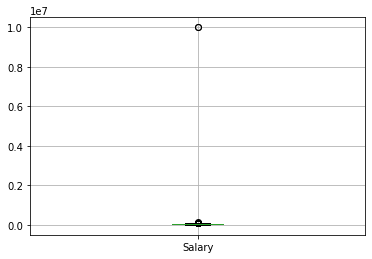

In [166]:
# With Outliars
df.boxplot(column = "Salary")

<AxesSubplot:>

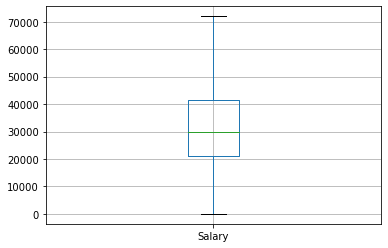

In [167]:
# Without Outliars
df.boxplot(column = "Salary", sym = '')

In [168]:
# Max values
df.loc[df["Salary"] > 100000]

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
12885,70187048,Temporary Permanent Vehicle Technician,Yeovil,non-specified,full_time,non-specified,Engineering Jobs,10000000.00,2012-01-26 15:00:00,2012-03-26 15:00:00,Jobcentre Plus
28158,68536767,Deputy Manager Rotherham,Rotherham,Populus Healthcare,full_time,non-specified,Healthcare & Nursing Jobs,10000000.00,2012-04-27 00:00:00,2012-05-27 00:00:00,staffnurse.com
30191,69546028,Principle SQL Database Engineer DTS OLTP SSIS,South East London,Mortimer Spinks,non-specified,permanent,IT Jobs,150000.00,2012-12-16 12:00:00,2013-02-14 12:00:00,cwjobs.co.uk
45190,71138843,Global Portfolio Manager Renewable Energy,London,RSA,non-specified,permanent,Accounting & Finance Jobs,120000.00,2012-06-20 15:00:00,2012-09-18 15:00:00,insurancejobs.co.uk


In [169]:
# No negative Salaries. Good.
df.loc[df["Salary"] < 0].shape

(0, 11)

In [170]:
# So every Salary under 5000 is actually 0. 
df.loc[df["Salary"] < 5000].Salary.value_counts()

0.00    3127
Name: Salary, dtype: int64

Lets now consider the outliars to be anything > 500k and anything < 1k.

Lets replace these with the average value.

### 6.2 Finding Average Pay

Lets first find the average pay of everyone, then we can use that to replace the non-acceptable values

In [171]:
# Filtering all the Salaries without Outliers
clean_salary = df["Salary"][(df["Salary"] > 1000)&(df["Salary"] < 500000)]
clean_salary[0]

32000.0

In [172]:
# Making Avg Salary
avg_pay = clean_salary.sum()/clean_salary.notna().sum()
avg_pay

34452.197204120246

In [173]:
err_index = df.loc[(df.Salary >500000)|(df.Salary <1000),'Salary'].index

In [174]:
df.loc[(df.Salary >500000)|(df.Salary <1000),'Salary'] = avg_pay

In [175]:
df.loc[12885]["Salary"]

34452.197204120246

In [176]:
# Don't forget to round it again since we added new values to Salary
df["Salary"] = round(df["Salary"],2)
df.loc[12885]["Salary"]

34452.2

In [177]:
# Record the errors
for i in err_index:
    updateErlist(i, df.loc[i]['Id'], 'Salary', ori_df.loc[i]["Salary"], df.loc[i]['Salary'], "Salary was Abnormal Outlier", "Replaced with the average pay")

## 7 Checking for valid values

In [178]:
df.Category.value_counts()

IT Jobs                             13132
Healthcare & Nursing Jobs            8183
Engineering Jobs                     7200
Accounting & Finance Jobs            6801
Sales Jobs                           4743
Hospitality & Catering Jobs          4530
Teaching Jobs                        3558
PR, Advertising & Marketing Jobs     2552
Name: Category, dtype: int64

In [179]:
df.ContractTime.value_counts()

permanent        30320
non-specified    14800
contract          5579
Name: ContractTime, dtype: int64

In [180]:
df.ContractType.value_counts()

non-specified    37432
full_time        11752
part_time         1515
Name: ContractType, dtype: int64

All columns are valid, as they all fit into the possible valid values.

## 8 Integrity Constraints

Lets check if any CloseDates are smaller than OpenDates, which shouldn't be possible.

In [181]:
df[df["OpenDate"]>df["CloseDate"]]

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
8562,71554931,Property Underwriter,Gloucestershire,Search Consultancy,non-specified,permanent,Accounting & Finance Jobs,30000.00,2013-12-15 12:00:00,2013-09-16 12:00:00,cv-library.co.uk
10680,71369315,Geotechnical Engineer / Geologist,Manchester,Peritus Green Associates Ltd,non-specified,permanent,Engineering Jobs,22500.00,2013-12-17 15:00:00,2013-11-17 15:00:00,cv-library.co.uk
24511,69731856,ASSISTANT FINANCIAL CONTROLLER CENTRAL LONDON,South East London,Kerry Robert Associates,non-specified,non-specified,Hospitality & Catering Jobs,35000.00,2013-10-28 00:00:00,2013-10-14 00:00:00,caterer.com
24534,69895838,Head Bartender The Haymarket Hotel,London,Firmdale,non-specified,non-specified,Hospitality & Catering Jobs,17500.00,2013-03-09 00:00:00,2013-01-08 00:00:00,caterer.com
25633,67378781,Commis chef Great Chance to learn in a Award w...,Chesterfield,Peaks & Dales Recruitment,non-specified,non-specified,Hospitality & Catering Jobs,13750.00,2013-06-04 15:00:00,2013-05-05 15:00:00,caterer.com


Oh interesting so these errors do exist!

Lets swap the OpenDate and CloseDate around, as thats probably what the entry meant, and we can save the rest of the data!

In [182]:
err_index = df[df["OpenDate"]>df["CloseDate"]].index
err_index

Int64Index([8562, 10680, 24511, 24534, 25633], dtype='int64')

In [183]:
for i in err_index:
    # Lets store the dates as variables so we can swap them
    clo = df.loc[i]["CloseDate"]
    ope = df.loc[i]["OpenDate"]
    # Now lets do the swap
    df["CloseDate"][i] = ope
    df["OpenDate"][i] = clo

<ipython-input-183-0640d1eb628c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CloseDate"][i] = ope
<ipython-input-183-0640d1eb628c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["OpenDate"][i] = clo


In [184]:
df.loc[8562]

Id                               71554931
Title                Property Underwriter
Location                  Gloucestershire
Company                Search Consultancy
ContractType                non-specified
ContractTime                    permanent
Category        Accounting & Finance Jobs
Salary                           30000.00
OpenDate              2013-09-16 12:00:00
CloseDate             2013-12-15 12:00:00
SourceName               cv-library.co.uk
Name: 8562, dtype: object

In [185]:
# Record Errors
for i in err_index:
    updateErlist(i, df.loc[i]['Id'], 'OpenDate, CloseDate', ori_df.loc[i]["OpenDate"], df.loc[i]["OpenDate"], "CloseDate earlier than OpenDate", "OpenDate and CloseDate swapped")

In [186]:
erlist.tail()

,indexOfdf,Id,ColumnName,Original,Modified,ErrorType,Fixing
85278,8562,71554931,"OpenDate, CloseDate",2013-12-15 12:00:00,2013-09-16 12:00:00,CloseDate earlier than OpenDate,OpenDate and CloseDate swapped
85279,10680,71369315,"OpenDate, CloseDate",2013-12-17 15:00:00,2013-11-17 15:00:00,CloseDate earlier than OpenDate,OpenDate and CloseDate swapped
85280,24511,69731856,"OpenDate, CloseDate",2013-10-28 00:00:00,2013-10-14 00:00:00,CloseDate earlier than OpenDate,OpenDate and CloseDate swapped
85281,24534,69895838,"OpenDate, CloseDate",2013-03-09 00:00:00,2013-01-08 00:00:00,CloseDate earlier than OpenDate,OpenDate and CloseDate swapped
85282,25633,67378781,"OpenDate, CloseDate",2013-06-04 15:00:00,2013-05-05 15:00:00,CloseDate earlier than OpenDate,OpenDate and CloseDate swapped


Wonderful. 

In [187]:
df.sample(10)

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
34257,68507928,"AUTOMOTIVE VEHICLE TECHNICIAN, BUCKINGHAMSHIRE",Beaconsfield,non-specified,full_time,permanent,Engineering Jobs,27500.00,2012-12-15 00:00:00,2013-01-14 00:00:00,fish4.co.uk
20578,68064417,RGN or RM Nurses,Henley-On-Thames,BROOK STREET BUREAU Hammersmith Care,non-specified,permanent,Healthcare & Nursing Jobs,29194.00,2012-08-16 15:00:00,2012-09-15 15:00:00,totaljobs.com
22121,65184570,Customer Services Representative,Redhill,Utility People Ltd,non-specified,permanent,Engineering Jobs,15500.00,2013-02-10 15:00:00,2013-04-11 15:00:00,totaljobs.com
13182,69956961,City Coordinator,UK,DDE Entertainment,full_time,non-specified,"PR, Advertising & Marketing Jobs",19992.00,2012-08-15 15:00:00,2012-11-13 15:00:00,Jobcentre Plus
24193,70144033,Reg Fast Food Trainer,West Midlands,Pertemps,non-specified,non-specified,Hospitality & Catering Jobs,16000.00,2013-01-04 15:00:00,2013-01-18 15:00:00,caterer.com
17742,71677110,Sales Executive Beauty,London,Tobias Recruitment Ltd,non-specified,permanent,Sales Jobs,28000.00,2012-09-07 12:00:00,2012-12-06 12:00:00,totaljobs.com
40570,68627487,Oracle R****i Functional Support,London,Proactive Appointments,non-specified,permanent,IT Jobs,55000.00,2013-07-01 12:00:00,2013-08-30 12:00:00,jobserve.com
30893,69036467,"Java Developer, (XP, TDD, Agile), ****k ****k",Richmond,Connections Recruitment Ltd.,non-specified,permanent,IT Jobs,65000.00,2012-05-31 00:00:00,2012-08-29 00:00:00,cwjobs.co.uk
44829,72114759,Service Design Transition Specialist,Southampton,non-specified,non-specified,permanent,IT Jobs,45900.00,2012-02-04 15:00:00,2012-04-04 15:00:00,securityclearedjobs.com
26228,68309545,Female Support Worker Physically Disabled Poole,Poole,Coburg Banks,full_time,non-specified,Healthcare & Nursing Jobs,16640.00,2013-11-28 00:00:00,2014-01-27 00:00:00,staffnurse.com


## Saving data
Save the parsed and cleaned data as well as the error list, named as:
- \<student\_id\>_dataset1_solution.csv
- \<student\_id\>_errorlist.csv

In [188]:
# code to save output data
df.to_csv('s3900098_dataset1_solution.csv', index = False)
erlist.to_csv('s3900098_errorlist.csv')

## Summary

Overall, we managed to successfully Parse the Data from XML format, and then further clean that data along with an error list recording every error.

During the XML Parsing stage, a particularly annoying aspect was how every Source had Records with differing amount of children (job details). This meant that if we captured it normally, each column would be of different lengths, which would mess with the DataFrame. The solution is to iterate through every single known child, for each and every record, regardless of whether they have the child or not. This allows Python to capture non-existnt children as empty cells, and all column names will be the same.

Another hard aspect was the cleaning of columns where strings contained certain characters we did not want. This required the use of Regex to properly solve.

Initially, because no message had been given, I assumed we had to clean the Title column, since there were multiple \**** and special characters that did not seem right. Turns out we didn't need to clean them, so that was 5+ hours gone. I suspect that is why we were given an extention...

Overall, this task has been a good learning experience, and I have learnt lots of new tricks used in the Lectures, and now remember them because I have applied them. 

It is also foolish of me to attempt this before reading the lecture activities, as there were many shortcuts shown that would have saved me lots of time!

I hope you enjoy - Denzel